In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
from urllib.parse import quote
import datetime
import scipy.special as special
import seaborn as sns
from datetime import datetime, timedelta
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import itertools
# import statsmodels.api as sm
from pylab import rcParams

import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)
warnings.filterwarnings("ignore")

# plt.rcParams['figure.figsize'] = (10, 10)
# plt.rcParams['grid.linestyle'] = ':'   
# plt.rcParams['axes.grid'] = True

# sns.set_style("whitegrid", {'axes.grid' : False})
#sns.color_palette("RdBu", n_colors=10)

np.float_ = np.float64

# %matplotlib inline
# %config InlineBackend.figure_formats = {'png', 'retina'}


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen


print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version', sns.__version__)

Importing plotly failed. Interactive plots will not work.


Numpy version 2.0.1
Pandas version 2.2.2
Seaborn version 0.13.2


In [2]:
cur_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("current times:", cur_time)

current times: 2024-08-05 17:08:06


In [3]:
dengue_x = pd.read_csv('./r506_pipeline/data/new_case.csv')
dengue_y = pd.read_csv('./temp_pipeline/data/dataset/temp_all.csv')
# dengue_x = pd.read_csv('./data/new_case.csv')
# dengue_y = pd.read_csv('./data/temp_all.csv')

# Merge the features and labels data
dengue_df = pd.merge(dengue_x, dengue_y, on=['station', 'date'])

In [4]:
dengue_df.head()

,station,date,total_case,temp
0,9601,2019-01-07,12,27.454255
1,9601,2019-01-14,9,27.487042
2,9601,2019-01-21,9,27.443323
3,9601,2019-01-28,6,27.272813
4,9601,2019-02-04,7,27.605421


In [5]:
# Select only the data for 9601
dengue_df = dengue_df[dengue_df['station'] == 9601]

In [6]:
dengue_df.drop(['station'], axis=1, inplace=True)
dengue_df['date'] = pd.to_datetime(dengue_df['date'])
dengue_df.set_index('date', inplace=True)

In [7]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2019-01-07 to 2023-12-25
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  260 non-null    int64  
 1   temp        260 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.1 KB


In [8]:
dengue_df = dengue_df.resample('W-MON').mean().interpolate(method='linear')

In [9]:
def get_forecast_accuracy(y, y_hat):
    # ME
    me = (y - y_hat).sum()/len(y)

    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_hat))

    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat) * 100
    
    # WAPE
    wape = (y - y_hat).__abs__().sum() / y.__abs__().sum() * 100

    print("ME: %.2f, RMSE: %.2f, MAPE: %.2f%%, WAPE: %.2f%%" % (me,rmse,mape,wape))

In [10]:
# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':dengue_df.index,'y':dengue_df.total_case})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts.describe()

,ds,y
count,260,260.000000
mean,2021-07-01 12:00:00,4.726923
min,2019-01-07 00:00:00,0.000000
25%,2020-04-04 06:00:00,0.000000
50%,2021-07-01 12:00:00,2.000000
75%,2022-09-27 18:00:00,7.000000
max,2023-12-25 00:00:00,31.000000
std,NaN,5.953362


<Axes: xlabel='date'>

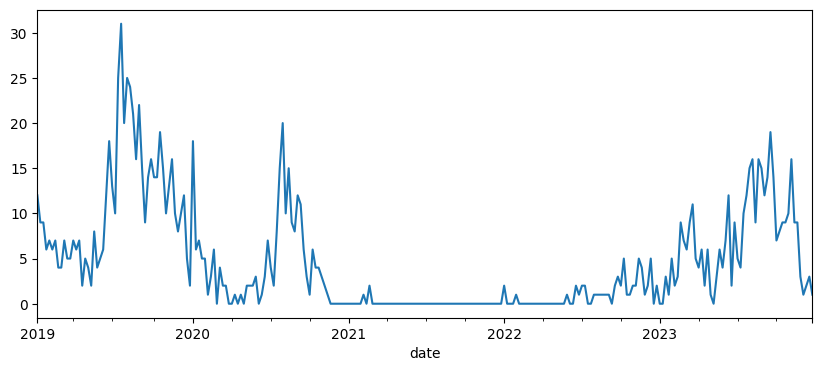

In [11]:
ts['y'].plot(figsize=(10,4))

00:55:43 - cmdstanpy - INFO - Chain [1] start processing
00:55:44 - cmdstanpy - INFO - Chain [1] done processing


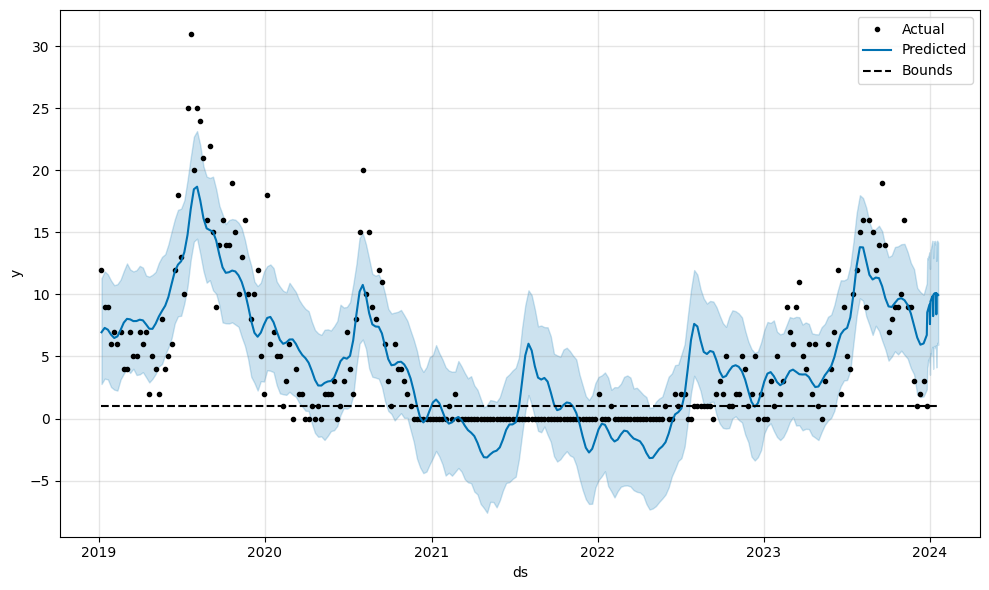

In [12]:
# instantiate the model and fit the timeseries
prophet = Prophet(yearly_seasonality=True, 
                  daily_seasonality=True, 
                  weekly_seasonality=True,
                  growth='linear',
                  n_changepoints= 10,
                  changepoint_range=1, # Consider the whole range for change points
                  changepoint_prior_scale=0.4) # Adjust trend flexibility if it overfits (too large) or underfits (too small).
                                               # Higher value = More flexible trend
prophet.fit(ts)

# Create additional points 25 periods into a future data frame 
future = prophet.make_future_dataframe(periods=25)
future['cap'] = 1
future['floor'] = 0
forecast = prophet.predict(future)

# plot
fig = prophet.plot(forecast)
ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Bounds'])  
pass; 

In [13]:
# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-07,6.953366,2.778876,11.304793
1,2019-01-14,7.304560,3.213473,11.858331
2,2019-01-21,7.160190,3.152540,11.615525
3,2019-01-28,6.763507,2.537633,11.120117
4,2019-02-04,6.490317,2.326962,10.745973


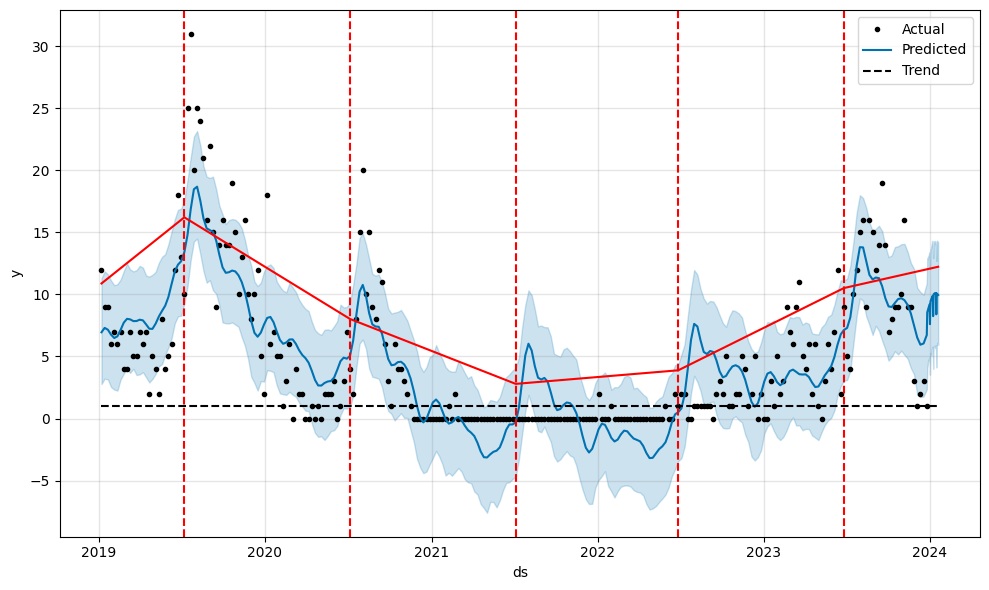

In [14]:
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Trend'])  

In [15]:
dengue_df.to_csv(r"data\case_9601.csv")

varmar

In [6]:
case = pd.read_csv("./dengue_model/data/new_case.csv", encoding="cp874" )
temp = pd.read_csv("./dengue_model/data/temp_all.csv", encoding="cp874")
rain = pd.read_csv("./dengue_model/data/rain_all.csv", encoding="cp874")
press = pd.read_csv("./dengue_model/data/press_all.csv", encoding="cp874")
humidity = pd.read_csv("./dengue_model/data/humid_all.csv", encoding="cp874")

In [28]:
case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   station     3367 non-null   int64 
 1   date        3367 non-null   object
 2   total_case  3367 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 79.0+ KB


In [7]:
df = case.merge(temp,on=['date', 'station'],how='left')
df = df.merge(press,on=['date', 'station'],how='left')
df = df.merge(humidity,on=['date', 'station'],how='left')
df = df.merge(rain,on=['date', 'station'],how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     3367 non-null   int64  
 1   date        3367 non-null   object 
 2   total_case  3367 non-null   int64  
 3   temp        3367 non-null   float64
 4   press       3367 non-null   float64
 5   humid       3367 non-null   float64
 6   rain        3367 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 184.3+ KB


In [8]:
uscon = df

In [9]:
uscon.head()

,station,date,total_case,temp,press,humid,rain
0,9601,2019-01-07,12,27.454255,1008.002678,86.836500,12.184034
1,9601,2019-01-14,9,27.487042,1007.790922,85.787632,8.462447
2,9601,2019-01-21,9,27.443323,1007.519514,83.333627,6.638479
3,9601,2019-01-28,6,27.272813,1008.248065,81.794925,3.341892
4,9601,2019-02-04,7,27.605421,1008.213114,81.841144,3.604828


In [10]:
print('Series has {} missing values'.format(uscon.isna().sum()))
date_missed = uscon[uscon.isna()].index

Series has station       0
date          0
total_case    0
temp          0
press         0
humid         0
rain          0
dtype: int64 missing values


In [11]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     3367 non-null   int64  
 1   date        3367 non-null   object 
 2   total_case  3367 non-null   int64  
 3   temp        3367 non-null   float64
 4   press       3367 non-null   float64
 5   humid       3367 non-null   float64
 6   rain        3367 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 184.3+ KB


In [123]:
# uscon.drop(['index'], axis=1, inplace=True)

In [214]:
# Select only the data for 9601
uscon = uscon[uscon['station'] == 9601]

In [12]:
uscon.head()

,station,date,total_case,temp,press,humid,rain
0,9601,2019-01-07,12,27.454255,1008.002678,86.836500,12.184034
1,9601,2019-01-14,9,27.487042,1007.790922,85.787632,8.462447
2,9601,2019-01-21,9,27.443323,1007.519514,83.333627,6.638479
3,9601,2019-01-28,6,27.272813,1008.248065,81.794925,3.341892
4,9601,2019-02-04,7,27.605421,1008.213114,81.841144,3.604828


In [293]:
# uscon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2019-01-07 to 2023-12-25
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     260 non-null    int64  
 1   total_case  260 non-null    int64  
 2   temp        260 non-null    float64
 3   press       260 non-null    float64
 4   humid       260 non-null    float64
 5   rain        260 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 14.2 KB


In [13]:
uscon[uscon['total_case'] == 0]

,station,date,total_case,temp,press,humid,rain
60,9601,2020-03-02,0,27.446738,1006.306533,81.601594,0.002381
64,9601,2020-03-30,0,29.099490,1004.920012,79.686048,0.083333
65,9601,2020-04-06,0,28.973941,1005.576618,81.862832,2.416667
67,9601,2020-04-20,0,29.926497,1005.560649,79.407853,1.073810
69,9601,2020-05-04,0,28.127691,1005.135167,83.466337,4.107143
...,...,...,...,...,...,...,...
3283,9613,2022-05-30,0,28.245238,1006.586310,80.245238,1.285714
3286,9613,2022-06-20,0,27.884146,1007.247273,83.165868,12.371429
3296,9613,2022-08-29,0,27.844848,1006.425455,84.602410,12.257143
3316,9613,2023-01-16,0,27.211515,1008.726506,81.562651,7.228571


In [14]:
# Reset the MultiIndex to work with 'date' as a regular column
df_reset = uscon.reset_index()

# Set 'date' as the index for resampling
df_reset['date'] = pd.to_datetime(df_reset['date'])
df_reset.set_index('date', inplace=True)

In [16]:
df_reset.drop(['index','station'], axis=1, inplace=True)

In [17]:
df_reset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3367 entries, 2019-01-07 to 2024-01-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  3367 non-null   int64  
 1   temp        3367 non-null   float64
 2   press       3367 non-null   float64
 3   humid       3367 non-null   float64
 4   rain        3367 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 157.8 KB


In [181]:
# df_reset = df_reset.drop(['index','station'], axis=1, inplace=True)

In [18]:
df_reset[df_reset['total_case'] == 0]

,total_case,temp,press,humid,rain
date,,,,,
2020-03-02,0,27.446738,1006.306533,81.601594,0.002381
2020-03-30,0,29.099490,1004.920012,79.686048,0.083333
2020-04-06,0,28.973941,1005.576618,81.862832,2.416667
2020-04-20,0,29.926497,1005.560649,79.407853,1.073810
2020-05-04,0,28.127691,1005.135167,83.466337,4.107143
...,...,...,...,...,...
2022-05-30,0,28.245238,1006.586310,80.245238,1.285714
2022-06-20,0,27.884146,1007.247273,83.165868,12.371429
2022-08-29,0,27.844848,1006.425455,84.602410,12.257143


In [255]:
df_reset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2019-01-07 to 2023-12-25
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  260 non-null    int64  
 1   temp        260 non-null    float64
 2   press       260 non-null    float64
 3   humid       260 non-null    float64
 4   rain        260 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 12.2 KB


In [19]:
# Resample the DataFrame based on the 'date' index
df_resampled = df_reset.resample('W-mon').mean().interpolate(method='linear')
# weekly_summary = df_reset.resample('W-MON').mean().interpolate(method='linear')
# Reset index to reintroduce 'group' as a column
df_resampled = df_resampled.reset_index()

In [20]:
df_resampled = df_resampled.reset_index()

In [21]:
df_resampled[df_resampled['total_case'] == 0]

,index,date,total_case,temp,press,humid,rain
64,64,2020-03-30,0.0,29.099490,1004.920012,79.686048,0.083333
65,65,2020-04-06,0.0,28.973941,1005.576618,81.862832,2.416667
69,69,2020-05-04,0.0,28.127691,1005.135167,83.466337,4.107143
98,98,2020-11-23,0.0,26.491056,1005.255793,84.434721,10.691974
99,99,2020-11-30,0.0,25.714387,1005.388348,86.100549,25.457130
100,100,2020-12-07,0.0,25.865468,1005.250459,84.084893,15.166731
101,101,2020-12-14,0.0,26.681190,1004.326105,82.751384,3.629109
102,102,2020-12-21,0.0,25.736132,1004.430711,86.209484,40.296249
103,103,2020-12-28,0.0,26.439465,1002.800882,83.676746,7.918152
108,108,2021-02-01,0.0,26.424503,1004.218693,81.391156,2.622577


In [235]:
# df_resampled['date'] = pd.to_datetime(df_resampled['date'])
# df_resampled.set_index('date', inplace=True)

In [22]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       261 non-null    int64         
 1   date        261 non-null    datetime64[ns]
 2   total_case  261 non-null    float64       
 3   temp        261 non-null    float64       
 4   press       261 non-null    float64       
 5   humid       261 non-null    float64       
 6   rain        261 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.4 KB


In [240]:
# df_resampled.drop(['index','level_0'], axis=1, inplace=True)

In [243]:
df_resampled = df_resampled.reset_index()

In [26]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       261 non-null    int64         
 1   date        261 non-null    datetime64[ns]
 2   total_case  261 non-null    float64       
 3   temp        261 non-null    float64       
 4   press       261 non-null    float64       
 5   humid       261 non-null    float64       
 6   rain        261 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.4 KB


In [27]:
df_resampled.drop(['index'], axis=1, inplace=True)

In [28]:
df_resampled['date'] = pd.to_datetime(df_resampled['date'])
df_resampled.set_index('date', inplace=True)

<Figure size 1500x500 with 0 Axes>

KeyError: 'None of [RangeIndex(start=0, stop=3367, step=1)] are in the [index]'

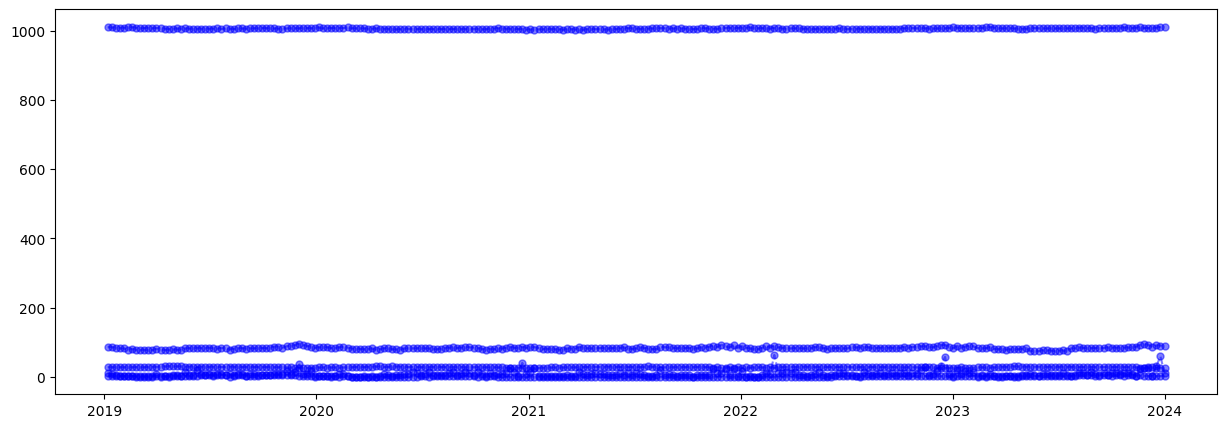

In [29]:
y_filled = df_resampled.interpolate(method='linear')

plt.figure(figsize=(15,5))
plt.plot(df_resampled, 'bo--', alpha=0.5, ms=5)
plt.plot(y_filled.loc[date_missed],'ro', ms=5)
plt.show()

<Axes: xlabel='date'>

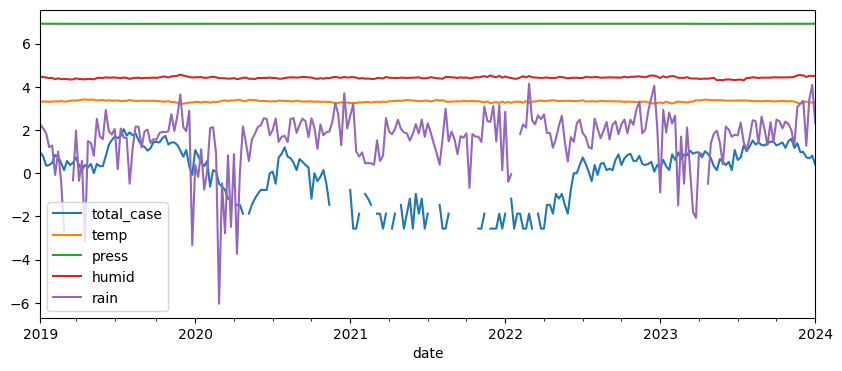

In [30]:
np.log(y_filled).plot(figsize=(10,4))

In [276]:
# uscon['date'] = pd.to_datetime(uscon['date'])
# uscon.set_index('date', inplace=True)

In [288]:
uscon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2019-01-07 to 2023-12-25
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     260 non-null    int64  
 1   total_case  260 non-null    int64  
 2   temp        260 non-null    float64
 3   press       260 non-null    float64
 4   humid       260 non-null    float64
 5   rain        260 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 14.2 KB


In [ ]:
model = VAR(uscon)
print(model.select_order())

In [285]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is trend stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is stostochastic trend")

In [286]:
for name, column in uscon.items():
    Augmented_Dickey_Fuller_Test_func(uscon[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: station


ValueError: Invalid input, x is constant

In [24]:
def cointegration_test(df): 
    res = coint_johansen(df,0,3)
    traces = res.lr1        # statistical test values
    cvts = res.cvt[:,1]     # critical value at 95% CI
    print('Column Name > Test Stat > C(95%) => Significant')
    print('----------------------------------------------')
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(col, '>', round(trace,2), ">", round(cvt,2), '=>' , trace > cvt)

In [25]:
cointegration_test(uscon)

Column Name > Test Stat > C(95%) => Significant
----------------------------------------------
total_case > 19.72 > 15.49 => True
temp > 6.29 > 3.84 => True


In [26]:
split_ratio = 0.7
train_size = int(len(uscon)*split_ratio)
Y_train, Y_test = uscon[:train_size], uscon[train_size:]

In [27]:
def grid_search_VARMA(Y_train, max_p, max_q):

    results = []

    pq = np.arange(max_p+1), np.arange(max_q+1) 

    for p, q in itertools.product(*pq):
        order = (p, q)
        if order != (0, 0):
            model = VARMAX(Y_train, order=order)
            model_fit = model.fit(disp=False)
            error = model_fit.aicc
            results.append((order, error))
            print(f'VARMAX{order} - AICC:{error}')

    return results

In [28]:
results = grid_search_VARMA(Y_train,3,3)

VARMAX(np.int64(0), np.int64(1)) - AICC:1544.7379242875907


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(np.int64(0), np.int64(2)) - AICC:1465.8418405267566


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(np.int64(0), np.int64(3)) - AICC:1458.408715303148
VARMAX(np.int64(1), np.int64(0)) - AICC:1328.0362121882783


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


VARMAX(np.int64(1), np.int64(1)) - AICC:1304.786070866862


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


VARMAX(np.int64(1), np.int64(2)) - AICC:1305.2483504997278


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(np.int64(1), np.int64(3)) - AICC:1295.6481319160594
VARMAX(np.int64(2), np.int64(0)) - AICC:1302.0692049024244


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


VARMAX(np.int64(2), np.int64(1)) - AICC:1301.5133204531382


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


VARMAX(np.int64(2), np.int64(2)) - AICC:1305.074847806295


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(np.int64(2), np.int64(3)) - AICC:1301.6989043767671
VARMAX(np.int64(3), np.int64(0)) - AICC:1287.1820077846744


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


VARMAX(np.int64(3), np.int64(1)) - AICC:1296.420640701861


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


VARMAX(np.int64(3), np.int64(2)) - AICC:1301.5330544449723


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(np.int64(3), np.int64(3)) - AICC:1311.3395845401403


In [29]:
# Print top 10 best models
print("\nTop 10 best VARMAX configurations:")
for i, (order, error) in enumerate(sorted(results, key=lambda x: x[1])[:10]):
    print(f'{i+1}: VARMAX{order} - AICC:{error}')


Top 10 best VARMAX configurations:
1: VARMAX(np.int64(3), np.int64(0)) - AICC:1287.1820077846744
2: VARMAX(np.int64(1), np.int64(3)) - AICC:1295.6481319160594
3: VARMAX(np.int64(3), np.int64(1)) - AICC:1296.420640701861
4: VARMAX(np.int64(2), np.int64(1)) - AICC:1301.5133204531382
5: VARMAX(np.int64(3), np.int64(2)) - AICC:1301.5330544449723
6: VARMAX(np.int64(2), np.int64(3)) - AICC:1301.6989043767671
7: VARMAX(np.int64(2), np.int64(0)) - AICC:1302.0692049024244
8: VARMAX(np.int64(1), np.int64(1)) - AICC:1304.786070866862
9: VARMAX(np.int64(2), np.int64(2)) - AICC:1305.074847806295
10: VARMAX(np.int64(1), np.int64(2)) - AICC:1305.2483504997278


In [31]:
best_pq = (3,0)

model = VARMAX(Y_train, order=best_pq, trend='c').fit(disp=False)
model.summary()

Dep. Variable:,"['total_case', 'temp']",No. Observations:,182
Model:,VAR(3),Log Likelihood,-624.725
,+ intercept,AIC,1283.450
Date:,"Mon, 05 Aug 2024",BIC,1337.918
Time:,00:58:38,HQIC,1305.531
Sample:,01-07-2019,,
,- 06-27-2022,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.14, 0.00",Jarque-Bera (JB):,"313.55, 1.83"
Prob(Q):,"0.71, 0.98",Prob(JB):,"0.00, 0.40"
Heteroskedasticity (H):,"0.02, 1.67",Skew:,"1.55, -0.20"


In [32]:
model.forecast(4)

,total_case,temp
2022-07-04,1.231078,28.339492
2022-07-11,1.926350,28.380186
2022-07-18,1.987370,28.342312
2022-07-25,2.092895,28.324142


<Figure size 1000x400 with 0 Axes>

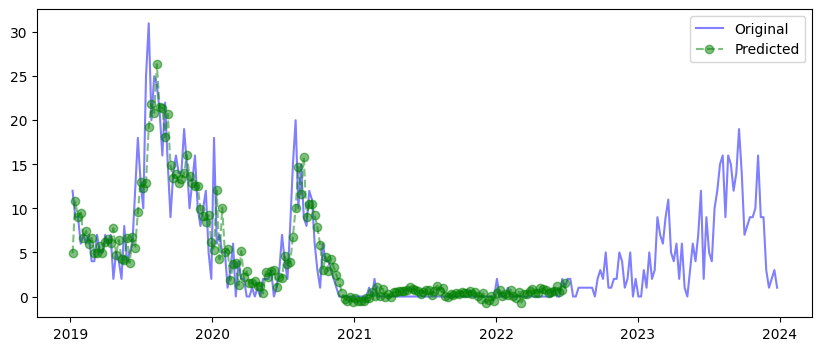

ME: -0.06, RMSE: 2.90, MAPE: 131210001430164944.00%, WAPE: 39.90%


In [33]:
plt.figure(figsize=(10,4))
plt.plot(uscon['total_case'], alpha=0.5, color='blue', label='Original')
plt.plot(model.predict()['total_case'], marker='o', linestyle='--', alpha=0.5, color='green', label='Predicted')
plt.legend()
plt.show()

get_forecast_accuracy(Y_train['total_case'], model.predict()['total_case'])

In [35]:
history = [y for y in Y_train.values]
train = history
predictions = list()
upper_ci = list()
lower_ci = list()


h = 4
for t in range(len(Y_test)-(h-1)):
      
  model_fit = VARMAX(train, order=best_pq).fit(disp=False)
    
  output = model_fit.get_forecast(h)
  predictions.append(output.predicted_mean[h-1])
  lower_ci.append(output.conf_int()[h-1, 0])
  upper_ci.append(output.conf_int()[h-1, 3])

  history.append(Y_test.iloc[t])
  train = history[t+1:]

<Figure size 800x400 with 0 Axes>

ME: 0.69, RMSE: 4.32, MAPE: 101062936713810448.00%, WAPE: 59.62%


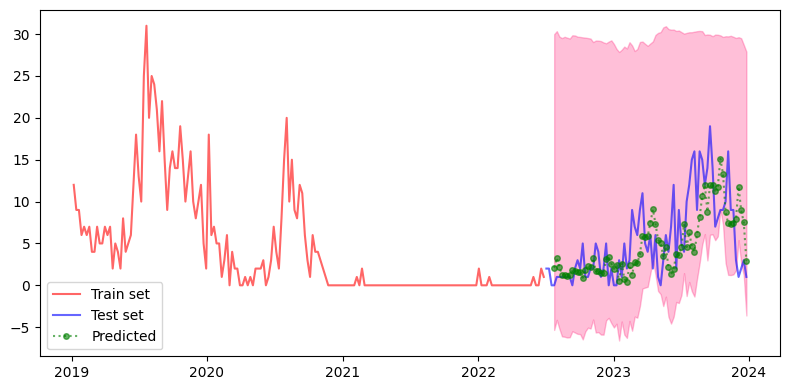

In [36]:
plt.figure(figsize=(8,4))
plt.plot(Y_train['total_case'], label='Train set', color='red', alpha=0.6); 
plt.plot(Y_test['total_case'], label='Test set', color='blue', alpha=0.6); 

predictions_con = pd.Series([i[0] for i in predictions], index=Y_test.index[h-1:])
plt.plot(predictions_con, 'go:', label='Predicted', alpha=0.6, ms=4) 
plt.fill_between(Y_test.index[h-1:], upper_ci, lower_ci, color='#ff0066', alpha=.25)
plt.legend(loc='best')
plt.tight_layout();

get_forecast_accuracy(Y_test['total_case'][h-1:], predictions_con)

In [37]:
results = model.forecast(h)
results['total_case'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 4 entries, 2022-07-04 to 2022-07-25
Freq: W-MON
Series name: total_case
Non-Null Count  Dtype  
--------------  -----  
4 non-null      float64
dtypes: float64(1)
memory usage: 64.0 bytes


In [50]:

# Define the total number of days to forecast (4 steps of 7 days each)
n_forecast_days = 4 

# Generate the forecast
forecast = model.get_forecast(steps=n_forecast_days)

# Create a date range starting from the day after the last date of the training data for 28 days
last_date = Y_test.index[-1]

# Generate the start date for each step
forecast_dates = [last_date + timedelta(weeks=1 * i) for i in range(n_forecast_days)]
# forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_forecast_days)

# Convert the forecasted mean to a DataFrame and assign the date range as the index
forecast_mean = forecast.predicted_mean
forecast_mean.index = forecast_dates

# Print the forecast with dates
print(forecast_mean)
forecast_mean.info()

            total_case       temp
2023-12-25    1.231078  28.339492
2024-01-01    1.926350  28.380186
2024-01-08    1.987370  28.342312
2024-01-15    2.092895  28.324142
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4 entries, 2023-12-25 to 2024-01-15
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_case  4 non-null      float64
 1   temp        4 non-null      float64
dtypes: float64(2)
memory usage: 96.0 bytes


In [51]:
# Convert 'total_case' column to a Series
total_case_series = forecast_mean['total_case']
total_case_series = forecast_mean.loc[:, 'total_case']
# total_case_series = forecast_mean.loc[:, 'total_case', 'temp']
total_case_series = forecast_mean['total_case']

In [52]:
# Convert Series to DataFrame
total_case_series = total_case_series.reset_index()
total_case_series.columns = ['date', 'total_case']
# Set the 'date' column as the index
total_case_series.set_index('date', inplace=True)
total_case_series

,total_case
date,
2023-12-25,1.231078
2024-01-01,1.926350
2024-01-08,1.987370
2024-01-15,2.092895


<Figure size 800x400 with 0 Axes>

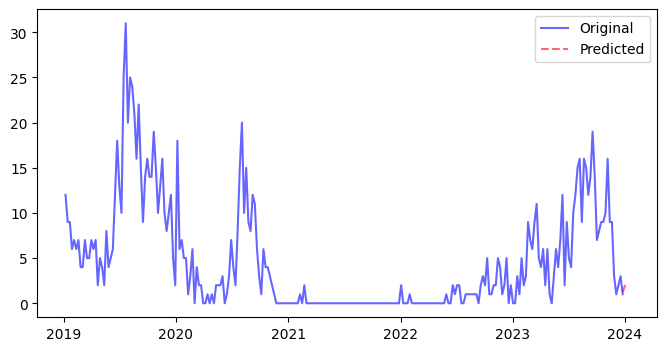

In [53]:
plt.figure(figsize=(8,4))
plt.plot(uscon['total_case'], alpha=0.6, color='blue', label='Original')
plt.plot(total_case_series['total_case'], linestyle='--', alpha=0.6, color='red', label='Predicted')
plt.legend()
plt.show()

In [54]:
uscon.tail()

,total_case,temp
date,,
2023-11-27,3.0,25.114773
2023-12-04,1.0,25.849286
2023-12-11,2.0,27.648078
2023-12-18,3.0,26.531403
2023-12-25,1.0,26.235534


In [55]:
forecast_mean.head()

,total_case,temp
2023-12-25,1.231078,28.339492
2024-01-01,1.926350,28.380186
2024-01-08,1.987370,28.342312
2024-01-15,2.092895,28.324142
